# An Introduction to SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)

In [1]:
import boto3
import botocore
import sagemaker
import sys


bucket = 'beyoung-sagemaker'   # <--- specify a bucket you have access to
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://beyoung-sagemaker/sagemaker/rcf-benchmarks


## Obtain and Inspect Example Data


Our data comes from the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset [[1](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv)]. These data consists of the number of New York City taxi passengers over the course of six months aggregated into 30-minute buckets. We know, a priori, that there are anomalous events occurring during the NYC marathon, Thanksgiving, Christmas, New Year's day, and on the day of a snow storm.

> [1] https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

In [2]:
%%time

import pandas as pd
import urllib.request

data_filename = 'nyc_taxi.csv'
data_source = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

urllib.request.urlretrieve(data_source, data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=',')

CPU times: user 23.4 ms, sys: 3.65 ms, total: 27.1 ms
Wall time: 259 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [3]:
taxi_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Human beings are visual creatures so let's take a look at a plot of the data.

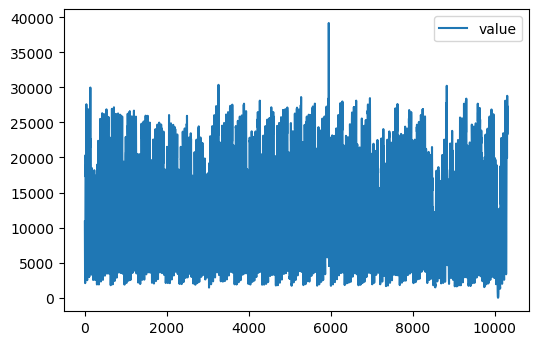

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

taxi_data.plot()

Human beings are also extraordinarily good at perceiving patterns. Note, for example, that something uncharacteristic occurs at around datapoint number 6000. Additionally, as we might expect with taxi ridership, the passenger count appears more or less periodic. Let's zoom in to not only examine this anomaly but also to get a better picture of what the "normal" data looks like.

In [ ]:
taxi_data[5500:6500].plot()

Here we see that the number of taxi trips taken is mostly periodic with one mode of length approximately 50 data points. In fact, the mode is length 48 since each datapoint represents a 30-minute bin of ridership count. Therefore, we expect another mode of length $336 = 48 \times 7$, the length of a week. Smaller frequencies over the course of the day occur, as well.

For example, here is the data across the day containing the above anomaly:

In [ ]:
taxi_data[5952:6000]

In [15]:
gw_data = taxi_data.copy()
print(gw_data.drop(gw_data.columns[0], axis=1).values)

[[10844]
 [ 8127]
 [ 6210]
 ...
 [27309]
 [26591]
 [26288]]


In [59]:
rcf_train = gw_data.drop(gw_data.columns[0], axis=1).values
print(f'type: {type(rcf_train)}, shape: {rcf_train.shape}, ndim: {rcf_train.ndim}')

type: <class 'numpy.ndarray'>, shape: (10320, 1), ndim: 2


In [58]:
a_train = taxi_data.values[:,1]
print(f'type: {type(a_train)}, shape: {a_train.shape}, ndim: {a_train.ndim}')

type: <class 'numpy.ndarray'>, shape: (10320,), ndim: 1


In [60]:
b_train = np.expand_dims(a_train, axis=1)
print(f'type: {type(b_train)}, shape: {b_train.shape}, ndim: {b_train.ndim}')

type: <class 'numpy.ndarray'>, shape: (10320, 1), ndim: 2


# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the taxi cab data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [16]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
# rcf.fit(rcf.record_set(taxi_data.value.as_matrix().reshape(-1,1)))
rcf.fit(rcf.record_set(gw_data.drop(gw_data.columns[0], axis=1).values))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-14 12:41:08 Starting - Starting the training job...
2020-07-14 12:41:10 Starting - Launching requested ML instances......
2020-07-14 12:42:19 Starting - Preparing the instances for training...............
2020-07-14 12:45:06 Downloading - Downloading input data......
2020-07-14 12:46:06 Training - Training image download completed. Training in progress.
2020-07-14 12:46:06 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[07/14/202


2020-07-14 12:46:13 Completed - Training job completed
Training seconds: 67
Billable seconds: 67


If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [17]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2020-07-14-12-41-07-905


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [18]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge'
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [19]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2020-07-14-12-41-07-905


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [22]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [ ]:
# taxi_data_numpy = taxi_data.value.as_matrix().reshape(-1,1)
# print(taxi_data_numpy[:6])
# results = rcf_inference.predict(taxi_data_numpy[:6])

In [46]:
results = rcf_inference.predict(rcf_train[:6])
results

{'scores': [{'score': 0.9436746378},
  {'score': 0.9236735762},
  {'score': 0.9545808127},
  {'score': 0.8679444009},
  {'score': 0.8980794608},
  {'score': 0.9046484086}]}

In [48]:
print(rcf_train[:6])

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [47]:
results = rcf_inference.predict(rcf_train)
scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
taxi_data['score'] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.943675
1,2014-07-01 00:30:00,8127,0.923674
2,2014-07-01 01:00:00,6210,0.954581
3,2014-07-01 01:30:00,4656,0.867944
4,2014-07-01 02:00:00,3820,0.898079


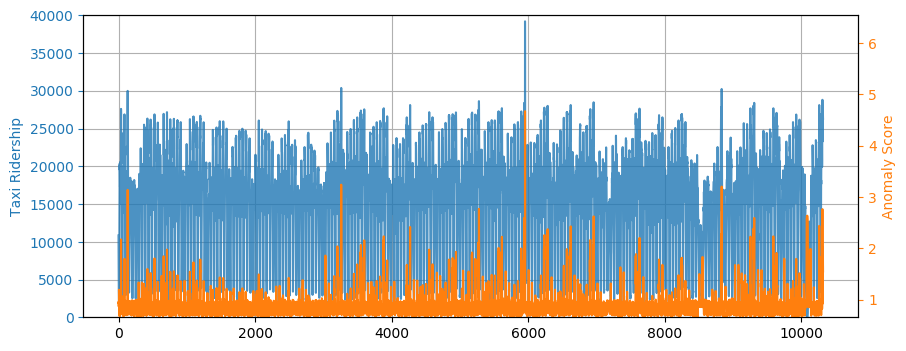

In [49]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
#start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset['value'], color='C0', alpha=0.8)
ax2.plot(taxi_data_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [50]:
score_mean = taxi_data['score'].mean()
score_std = taxi_data['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = taxi_data_subset[taxi_data_subset['score'] > score_cutoff]
anomalies

,timestamp,value,score
37,2014-07-01 18:30:00,27598,2.172982
38,2014-07-01 19:00:00,26827,1.785261
87,2014-07-02 19:30:00,26872,1.796464
134,2014-07-03 19:00:00,29985,3.136899
527,2014-07-11 23:30:00,26873,1.802558
...,...,...,...
10309,2015-01-31 18:30:00,27286,2.005610
10310,2015-01-31 19:00:00,28804,2.762051
10311,2015-01-31 19:30:00,27773,2.259142
10317,2015-01-31 22:30:00,27309,2.015797


The following is a list of known anomalous events which occurred in New York City within this timeframe:

* `2014-11-02` - NYC Marathon
* `2015-01-01` - New Year's Eve
* `2015-01-27` - Snowstorm

Note that our algorithm managed to capture these events along with quite a few others. Below we add these anomalies to the score plot.

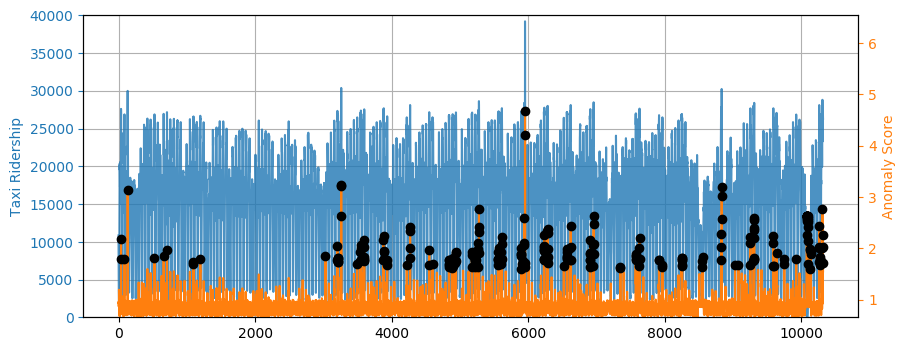

In [51]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [52]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a taxi ridership dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as the NYC taxi dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [53]:
import numpy as np

def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = 'sagemaker/randomcutforest_shingled'
taxi_data_shingled = shingle(taxi_data.values[:,1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


In [54]:
taxi_data_shingled.shape

(10272, 48)

We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [55]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled), wait=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [56]:
rcf.latest_training_job.job_name

'randomcutforest-2020-07-14-13-25-57-676'

In [61]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
    wait=False
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [62]:
rcf_inference.endpoint

'randomcutforest-2020-07-14-13-25-57-676'

In [63]:
rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [64]:
# Score the shingled datapoints
results = rcf_inference.predict(taxi_data_shingled)
scores = np.array([datum['score'] for datum in results['scores']])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3*score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.43642876 1.43969679 1.44961751 1.45384917 1.43741133 1.50104177
 1.62421825 1.59530753 1.6097478  1.60083847 1.5946436  1.56207472
 1.60360013 1.62269249 1.66227825 1.65493995 1.6909691  1.62095807
 1.63000111 1.63975276 1.67465584 1.68529013 1.67460279 1.63125462
 1.72359126 1.6876701  1.62708634 1.61105019 1.56189279 1.59208497
 1.50750419 1.4782284  1.53134452 1.49090187 1.43986121 1.46996139
 1.51548836 1.52551698 1.62993178 1.45927016 1.47421426 1.44398882
 1.45691919 1.48349271 1.55096983 1.52107464 1.46914781 1.52486771
 1.4690881  1.52685164 1.57985003 1.55887339 1.55477617 1.55802014
 1.53851482 1.55726559 1.53217054 1.59330367 1.52249952 1.46505326
 1.50184854 1.5058137  1.52383035 1.52549911 1.54601105 1.50097087
 1.50222862 1.45390505 1.45364609 1.43865064 1.44697645 1.48139036
 1.47148341 1.44362136 1.50615898 1.55385045 1.56329    1.58344282
 1.58478573 1.66677716 1.71391282 1.797386   1.77013999 1.76822389
 1.85089449 1.85966712 1.88491979 1.87061999 1.87870424 1.9139

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

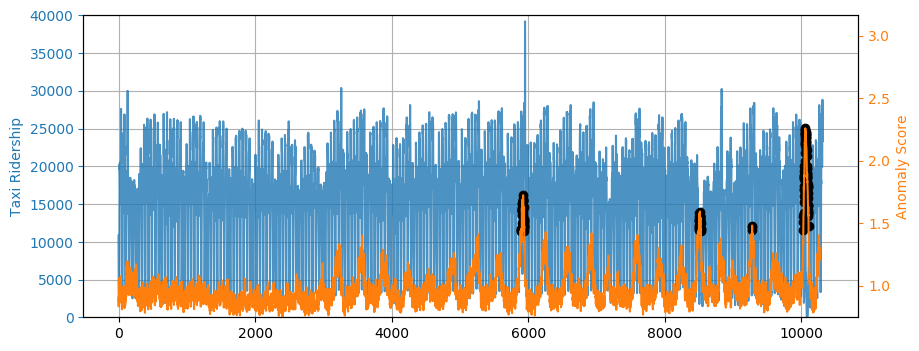

In [65]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data['value'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

We see that with this particular shingle size, hyperparameter selection, and anomaly cutoff threshold that the shingled approach more clearly captures the major anomalous events: the spike at around t=6000 and the dips at around t=9000 and t=10000. In general, the number of trees, sample size, and anomaly score cutoff are all parameters that a data scientist may need experiment with in order to achieve desired results. The use of a labeled test dataset allows the used to obtain common accuracy metrics for anomaly detection algorithms. For more information about Amazon SageMaker Random Cut Forest see the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

In [66]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)